# DenseNet CiFAR10

- Max validation accuracy achieved: 82.27%
- Optimizer: SGD
- Cyclic learning rate
- Augumentation used:
  - Noise
  - Blur
  - Flip
  - Translation
  - Zoom
  - Equalize
  - Rotation
- Trained network on two different dimension of datasets
- Number of Epochs
  - First Run: 46
  - Second Run: 50
  - Third Run: 50
  - Fourth Run: 12

---

### Keras Installation

In [1]:
# https://keras.io/
!pip install -q keras
import keras

notebook 5.4.0 requires ipykernel, which is not installed.
jupyter 1.0.0 requires ipykernel, which is not installed.
jupyter-console 5.2.0 requires ipykernel, which is not installed.
ipywidgets 7.1.1 requires ipykernel>=4.5.1, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.
Using TensorFlow backend.


### Import Dependencies

In [2]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import imgaug as ia
from imgaug import augmenters as iaa
from imgaug import parameters as iap

import cv2
import numpy as np
import random

from clr_callback import *

### GPU Configuration

In [3]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

### Hyperparameters

In [4]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 50

l = 36
num_filter = 12

compression = 0.5
dropout_rate = 0.3

clr_triangular = CyclicLR(base_lr=0.05, max_lr=0.5, step_size=2000., mode='triangular2')

### Load Data

In [5]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(len(x_train))

50000


### Data Sample

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


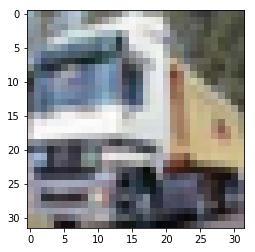

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

print(y_train[1])
plt.imshow(x_train[1])

### Data Augumentation

In [7]:
augmented_X, augmented_Y = [], []

noise = iaa.AdditiveGaussianNoise(scale=0.1*255)

for image,label in zip(x_train, y_train):
    augmented_X.append(image)
    augmented_Y.append(label)
    
   # Gaussian Noise
    augmented_X.append(noise.augment_image(image))
    augmented_Y.append(label)

    # Gaussian Blur
    augmented_X.append(cv2.GaussianBlur(image,(3,3),3))
    augmented_Y.append(label)
    
    # Horizontal Flip
    augmented_X.append(cv2.flip(image,1))
    augmented_Y.append(label)
    
    # Translation
    x = random.randint(-7, 7)
    y = random.randint(-7, 7)
    translation_mat = np.float32([[1,0,x],[0,1,y]])
    augmented_X.append(cv2.warpAffine(image, translation_mat, (img_width,img_height)))
    augmented_Y.append(label)
    
    # Zoom
    crop_img = image[3:29, 3:29]
    augmented_X.append(cv2.resize(crop_img, (img_width,img_height)))
    augmented_Y.append(label)
    
    # Equalize
    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    augmented_X.append(cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR))
    augmented_Y.append(label)
    
    # Rotation
    z = random.randint(-10, 10)
    M = cv2.getRotationMatrix2D((img_width,img_height),z,1)
    augmented_X.append(cv2.warpAffine(image,M,(img_width,img_height)))
    augmented_Y.append(label)

### Convert and Normalize Data

In [8]:
# Convert Images and Steering values to numpy arrays since keras requires them in that form
train_images = np.array(augmented_X)
train_labels = np.array(augmented_Y)
# print(len(X_train), len(Y_train))

train_images = train_images.astype('float32')
x_test = x_test.astype('float32')

train_images = train_images / 255
x_test = x_test / 255

### Display Augumentation

Text(0.5,1,'Rotation')

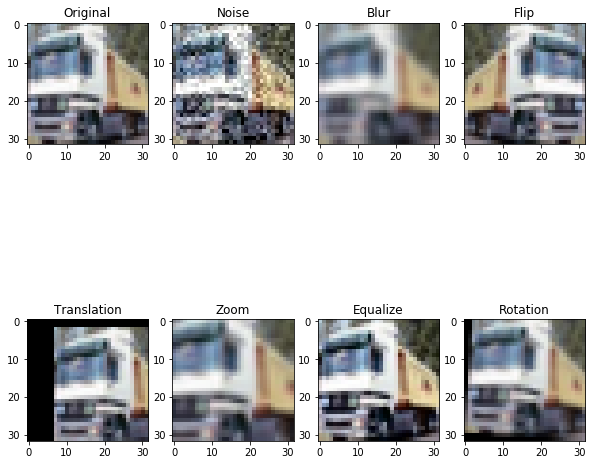

In [9]:
plt.figure(figsize=(10,10))

plt.subplot(2, 4, 1)
plt.imshow(train_images[8])
plt.title("Original")

plt.subplot(2, 4, 2)
plt.imshow(train_images[9])
plt.title("Noise")

plt.subplot(2, 4, 3)
plt.imshow(train_images[10])
plt.title("Blur")

plt.subplot(2, 4, 4)
plt.imshow(train_images[11])
plt.title("Flip")

plt.subplot(2, 4, 5)
plt.imshow(train_images[12])
plt.title("Translation")

plt.subplot(2, 4, 6)
plt.imshow(train_images[13])
plt.title("Zoom")

plt.subplot(2, 4, 7)
plt.imshow(train_images[14])
plt.title("Equalize")

plt.subplot(2, 4, 8)
plt.imshow(train_images[15])
plt.title("Rotation")

### DenseNet Architecture

![](https://github.com/Shilpaj1994/Phase1_assignments/blob/master/Assignment%204/DenseNet.png?raw=true)

### DenseNet Blocks

In [10]:
# Dense Block
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [11]:
def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [12]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

### Model 

In [13]:
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = MaxPooling2D(2)(input)
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(First_Conv2D)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [14]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 12)   324         max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 12)   48          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

### Compile

In [31]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

### Model Callbacks

In [32]:
filepath="train1\\model-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [clr_triangular, checkpoint]

### Model Training: 1st Run
- For first 3 training run, MaxPooling is used to reduce the dimension of training data by half
- This made the model converge faster

In [ ]:
model.fit(train_images, train_labels,
          batch_size = batch_size, 
          epochs=epochs,
          callbacks=callbacks_list,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 400000 samples, validate on 10000 samples
Epoch 1/50
400000/400000 [==============================] - 1273s 3ms/step - loss: 1.6754 - acc: 0.3690 - val_loss: 1.5869 - val_acc: 0.4759

Epoch 00001: val_acc improved from -inf to 0.47590, saving model to train1\model-01-0.48.hdf5
Epoch 2/50
400000/400000 [==============================] - 1143s 3ms/step - loss: 1.2884 - acc: 0.5335 - val_loss: 1.5136 - val_acc: 0.5022

Epoch 00002: val_acc improved from 0.47590 to 0.50220, saving model to train1\model-02-0.50.hdf5
Epoch 3/50
400000/400000 [==============================] - 1141s 3ms/step - loss: 1.1444 - acc: 0.5903 - val_loss: 1.2744 - val_acc: 0.6095

Epoch 00003: val_acc improved from 0.50220 to 0.60950, saving model to train1\model-03-0.61.hdf5
Epoch 4/50
400000/400000 [==============================] - 1142s 3ms/step - loss: 1.0711 - acc: 0.6177 - val_loss: 1.1649 - val_acc: 0.6462

Epoch 00004: val_acc improved from 0.60950 to 0.64620, saving model to train1\model-04-0.65.h

400000/400000 [==============================] - 1145s 3ms/step - loss: 0.6065 - acc: 0.7896 - val_loss: 0.9054 - val_acc: 0.7667

Epoch 00042: val_acc did not improve
Epoch 43/50
400000/400000 [==============================] - 1148s 3ms/step - loss: 0.6032 - acc: 0.7913 - val_loss: 0.9335 - val_acc: 0.7599

Epoch 00043: val_acc did not improve
Epoch 44/50
400000/400000 [==============================] - 1148s 3ms/step - loss: 0.5994 - acc: 0.7918 - val_loss: 0.9119 - val_acc: 0.7696

Epoch 00044: val_acc improved from 0.76810 to 0.76960, saving model to train1\model-44-0.77.hdf5
Epoch 45/50
400000/400000 [==============================] - 1157s 3ms/step - loss: 0.5946 - acc: 0.7933 - val_loss: 0.9494 - val_acc: 0.7593

Epoch 00045: val_acc did not improve
Epoch 46/50
400000/400000 [==============================] - 1158s 3ms/step - loss: 0.5912 - acc: 0.7946 - val_loss: 0.9323 - val_acc: 0.7615

Epoch 00046: val_acc did not improve
Epoch 47/50
 16640/400000 [>........................

---

### 2nd Training

In [30]:
from keras.models import load_model

model = load_model('train1\model-44-0.77.hdf5')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 12)   324         max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 12)   48          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
activation_117 (Activation)     (None, 2, 2, 36)     0           batch_normalization_117[0][0]    
__________________________________________________________________________________________________
conv2d_118 (Conv2D)             (None, 2, 2, 6)      1944        activation_117[0][0]             
__________________________________________________________________________________________________
dropout_117 (Dropout)           (None, 2, 2, 6)      0           conv2d_118[0][0]                 
__________________________________________________________________________________________________
concatenate_114 (Concatenate)   (None, 2, 2, 42)     0           concatenate_113[0][0]            
                                                                 dropout_117[0][0]                
__________________________________________________________________________________________________
batch_norm

In [33]:
model.fit(train_images, train_labels,
          batch_size = batch_size, 
          epochs=epochs,
          callbacks=callbacks_list,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 400000 samples, validate on 10000 samples
Epoch 1/50
   256/400000 [..............................] - ETA: 11:13:58 - loss: 0.4382 - acc: 0.8477

C:\Users\Shilpaj\AppData\Local\conda\conda\envs\GPU\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.376438). Check your callbacks.
  % delta_t_median)


400000/400000 [==============================] - 1218s 3ms/step - loss: 0.7538 - acc: 0.7388 - val_loss: 0.9049 - val_acc: 0.7363

Epoch 00001: val_acc improved from -inf to 0.73630, saving model to train1\model-01-0.74.hdf5
Epoch 2/50
400000/400000 [==============================] - 1190s 3ms/step - loss: 0.6652 - acc: 0.7714 - val_loss: 0.9562 - val_acc: 0.7343

Epoch 00002: val_acc did not improve
Epoch 3/50
400000/400000 [==============================] - 1190s 3ms/step - loss: 0.6299 - acc: 0.7823 - val_loss: 0.8524 - val_acc: 0.7691

Epoch 00003: val_acc improved from 0.73630 to 0.76910, saving model to train1\model-03-0.77.hdf5
Epoch 4/50
400000/400000 [==============================] - 1182s 3ms/step - loss: 0.6108 - acc: 0.7896 - val_loss: 0.7567 - val_acc: 0.7886

Epoch 00004: val_acc improved from 0.76910 to 0.78860, saving model to train1\model-04-0.79.hdf5
Epoch 5/50
400000/400000 [==============================] - 1173s 3ms/step - loss: 0.5910 - acc: 0.7957 - val_loss: 0.

400000/400000 [==============================] - 1387s 3ms/step - loss: 0.4928 - acc: 0.8294 - val_loss: 0.7364 - val_acc: 0.8089

Epoch 00043: val_acc improved from 0.80790 to 0.80890, saving model to train1\model-43-0.81.hdf5
Epoch 44/50
400000/400000 [==============================] - 1396s 3ms/step - loss: 0.4917 - acc: 0.8293 - val_loss: 0.7270 - val_acc: 0.8101

Epoch 00044: val_acc improved from 0.80890 to 0.81010, saving model to train1\model-44-0.81.hdf5
Epoch 45/50
400000/400000 [==============================] - 1391s 3ms/step - loss: 0.4903 - acc: 0.8307 - val_loss: 0.8160 - val_acc: 0.7956

Epoch 00045: val_acc did not improve
Epoch 46/50
400000/400000 [==============================] - 1387s 3ms/step - loss: 0.4889 - acc: 0.8305 - val_loss: 0.8249 - val_acc: 0.7941

Epoch 00046: val_acc did not improve
Epoch 47/50
400000/400000 [==============================] - 1388s 3ms/step - loss: 0.4878 - acc: 0.8310 - val_loss: 0.7314 - val_acc: 0.8074

Epoch 00047: val_acc did not 

---

### 3rd Training

In [14]:
from keras.models import load_model

model = load_model('train1\model-50-0.81.hdf5')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 12)   324         max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 12)   48          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
batch_normalization_127 (BatchN (None, 2, 2, 96)     384         concatenate_123[0][0]            
__________________________________________________________________________________________________
activation_127 (Activation)     (None, 2, 2, 96)     0           batch_normalization_127[0][0]    
__________________________________________________________________________________________________
conv2d_128 (Conv2D)             (None, 2, 2, 6)      5184        activation_127[0][0]             
__________________________________________________________________________________________________
dropout_127 (Dropout)           (None, 2, 2, 6)      0           conv2d_128[0][0]                 
__________________________________________________________________________________________________
concatenate_124 (Concatenate)   (None, 2, 2, 102)    0           concatenate_123[0][0]            
          

In [15]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [18]:
clr_triangular = CyclicLR(base_lr=0.05, max_lr=0.5, step_size=400000., mode='triangular2')

filepath="train1\\model-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [clr_triangular, checkpoint]

In [19]:
model.fit(train_images, train_labels,
          batch_size = batch_size, 
          epochs=epochs,
          callbacks=callbacks_list,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 400000 samples, validate on 10000 samples
Epoch 1/50
400000/400000 [==============================] - 1147s 3ms/step - loss: 0.5756 - acc: 0.8018 - val_loss: 0.6954 - val_acc: 0.8027

Epoch 00001: val_acc improved from -inf to 0.80270, saving model to train1\model-01-0.80.hdf5
Epoch 2/50
400000/400000 [==============================] - 2878s 7ms/step - loss: 0.5451 - acc: 0.8124 - val_loss: 0.7379 - val_acc: 0.7979

Epoch 00002: val_acc did not improve
Epoch 3/50
400000/400000 [==============================] - 1146s 3ms/step - loss: 0.5462 - acc: 0.8119 - val_loss: 0.7444 - val_acc: 0.7909

Epoch 00003: val_acc did not improve
Epoch 4/50
400000/400000 [==============================] - 1148s 3ms/step - loss: 0.5547 - acc: 0.8081 - val_loss: 0.8559 - val_acc: 0.7647

Epoch 00004: val_acc did not improve
Epoch 5/50
400000/400000 [==============================] - 1152s 3ms/step - loss: 0.5624 - acc: 0.8068 - val_loss: 0.8552 - val_acc: 0.7604

Epoch 00005: val_acc did not impro


Epoch 00043: val_acc did not improve
Epoch 44/50
400000/400000 [==============================] - 1150s 3ms/step - loss: 0.4481 - acc: 0.8446 - val_loss: 0.7247 - val_acc: 0.8033

Epoch 00044: val_acc did not improve
Epoch 45/50
400000/400000 [==============================] - 1154s 3ms/step - loss: 0.4505 - acc: 0.8442 - val_loss: 0.7234 - val_acc: 0.8012

Epoch 00045: val_acc did not improve
Epoch 46/50
400000/400000 [==============================] - 1159s 3ms/step - loss: 0.4532 - acc: 0.8428 - val_loss: 0.7256 - val_acc: 0.8061

Epoch 00046: val_acc did not improve
Epoch 47/50
400000/400000 [==============================] - 1154s 3ms/step - loss: 0.4554 - acc: 0.8426 - val_loss: 0.6907 - val_acc: 0.8087

Epoch 00047: val_acc did not improve
Epoch 48/50
400000/400000 [==============================] - 1154s 3ms/step - loss: 0.4571 - acc: 0.8419 - val_loss: 0.7697 - val_acc: 0.7908

Epoch 00048: val_acc did not improve
Epoch 49/50
400000/400000 [==============================] - 1

---

### 4th Training
- Removed the MaxPooling layer and used original dimension of the training images

In [10]:
model_1 = load_model('train1\model-34-0.82.hdf5')

In [11]:
model_1.layers.pop(1)

model_1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 12)   324         max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 12)   48          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 16, 16, 12)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
concatenate_125 (Concatenate)   (None, 2, 2, 108)    0           concatenate_124[0][0]            
                                                                 dropout_128[0][0]                
__________________________________________________________________________________________________
batch_normalization_129 (BatchN (None, 2, 2, 108)    432         concatenate_125[0][0]            
__________________________________________________________________________________________________
activation_129 (Activation)     (None, 2, 2, 108)    0           batch_normalization_129[0][0]    
__________________________________________________________________________________________________
conv2d_130 (Conv2D)             (None, 2, 2, 6)      5832        activation_129[0][0]             
__________________________________________________________________________________________________
dropout_12

In [12]:
# determine Loss function and Optimizer
model_1.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [13]:
filepath="train1\\model_1-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [clr_triangular, checkpoint]

In [14]:
model_1.fit(train_images, train_labels,
          batch_size = batch_size, 
          epochs=30,
          callbacks=callbacks_list,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 400000 samples, validate on 10000 samples
Epoch 1/30
400000/400000 [==============================] - 1165s 3ms/step - loss: 0.4624 - acc: 0.8398 - val_loss: 0.6358 - val_acc: 0.8222

Epoch 00001: val_acc improved from -inf to 0.82220, saving model to train1\model_1-01-0.82.hdf5
Epoch 2/30
400000/400000 [==============================] - 1135s 3ms/step - loss: 0.4436 - acc: 0.8469 - val_loss: 0.7200 - val_acc: 0.8078

Epoch 00002: val_acc did not improve
Epoch 3/30
400000/400000 [==============================] - 1137s 3ms/step - loss: 0.4334 - acc: 0.8504 - val_loss: 0.6815 - val_acc: 0.8207

Epoch 00003: val_acc did not improve
Epoch 4/30
400000/400000 [==============================] - 1138s 3ms/step - loss: 0.4276 - acc: 0.8517 - val_loss: 0.6814 - val_acc: 0.8217

Epoch 00004: val_acc did not improve
Epoch 5/30
400000/400000 [==============================] - 1139s 3ms/step - loss: 0.4210 - acc: 0.8536 - val_loss: 0.6878 - val_acc: 0.8204

Epoch 00005: val_acc did not imp

KeyboardInterrupt: 

---